# rsfMRI Preprocessing QA Notebook
---
Notebook for visualizing quality assurance outputs of the [Nipype resting state preprocessing script](https://github.com/gablab/openfmri/blob/openfmri/resting_state/rsfmri_vol_surface_preprocessing_nipy.py):
- registration (structural to MNI template: ANTS, functional to structural : bbregister)
- ART outliers
- segmentation masks (produced by FAST; used during noise filtering (aCompCor))
- Topup (to be added


The cells will display either brain slices or plots that allow for quick detection of potential problems. You must run the first 3 cells in order to use the rest of the notebook. 

You can also use this notebook to extract the average time series from specific aparc ROIs. 

See below for required packages.

(*updated Mar 14, 2017*)

In [1]:
%matplotlib inline

import os
import glob
import re
import fnmatch
import nilearn.plotting as nlp
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import pandas as pd
import seaborn as sns

import warnings

### Project-specific variables to change ###

In [6]:
rsfmri_dir = '/data/picsl/mackey_group/Ursula/ping/imaging/'
subj_prefix = 'P'
sublist_dir='/data/picsl/mackey_group/Ursula/ping/subjectData/subj_lists/10to13/'
#subj_subset = ['P1280', 'P1378', 'P1474'] 
              # set to None to see all subjects
with open(os.path.join(sublist_dir, 'sub_list_for_ppc_Siemens_full_10to13_withprocbold_nol.txt')) as sublist:
    subj_subset=sublist.readlines()
    subj_subset=map(str.strip, subj_subset) #use to read list from .txt file
outlier_threshold = 20    # percent 
ran_topup = False   # set to True if TOPUP was used

### Setting up subject list and # of vols for later use ###

In [7]:
def get_subjlist():
    if subj_subset == None:
        subjlist = [fl for fl in sorted(os.listdir(rsfmri_dir)) 
                    if fnmatch.fnmatch(fl, subj_prefix)]
    else:    
        subjlist = subj_subset
    return subjlist
    
def get_num_vols(subj):
    if ran_topup == True:
        rest_file = os.path.join(rsfmri_dir, subj, 'resting', 'timeseries', 'rest_01_roi_corrected.nii.gz')
    else:
        rest_file = os.path.join(rsfmri_dir, subj, 'resting', 'timeseries', 'rest_01.nii.gz')
    rest_img = nb.load(rest_file)
    return rest_img.shape[3]

# Registration #

In [8]:
def plot_anat(subj_path, title, fig=None, ax=None):
    anat2target = os.path.join(subj_path, 'resting', 'qa', 'ants', 'output_warped_image.nii.gz')
    close = False
    if ax is None:
        fig = plt.figure(figsize=(5, 2))
        ax = fig.gca()
        close = True
    display = nlp.plot_anat(anat_img=anat2target, cut_coords=(0, -13, 20), annotate=False,
                            draw_cross=False, title=title, figure=fig, axes=ax)
    if close:
        plt.show()
        display.close()

def get_mincost(subj_path, subj):
    if ran_topup == True:
        filename = 'median_bbreg_' + subj + '.dat.mincost'
        mincost_file = os.path.join(subj_path, 'resting', 'qa', 'mincost', filename)
        #unsure what the pathname is here
    else:
        filename = 'median_bbreg_' + subj + '.dat.mincost'
        mincost_file = os.path.join(subj_path, 'resting', 'qa', 'mincost',filename)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mincost=np.genfromtxt(mincost_file)[0]
    return mincost

### Check registration of structural to MNI template ###

Displays cross-sections of the output of ANTS registration (the structural image warped to the MNI template).

/data/picsl/mackey_group/Ursula/miniconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


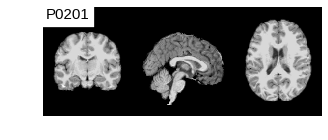

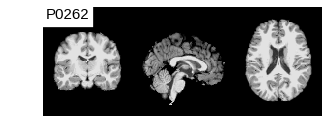

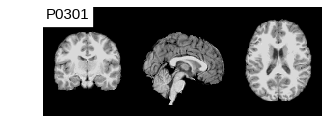

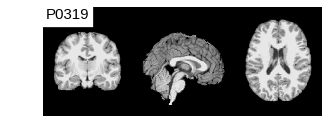

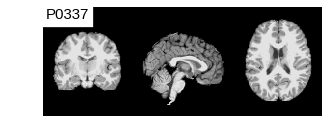

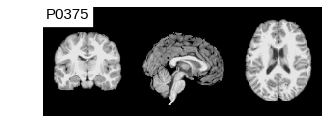

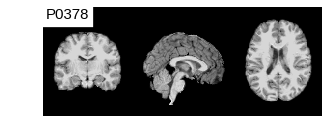

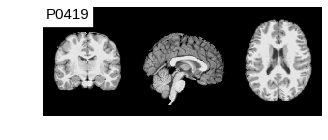

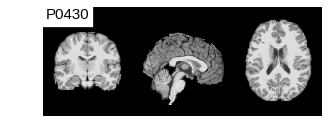

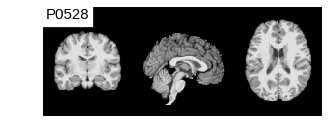

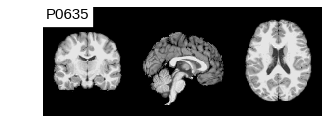

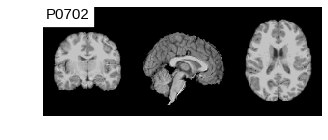

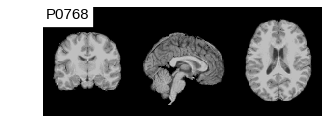

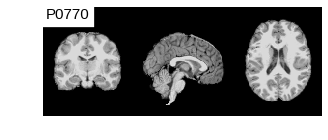

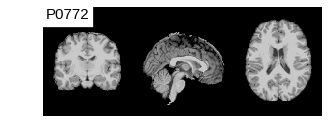

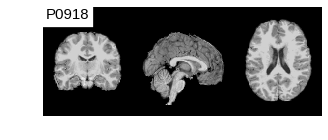

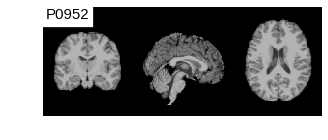

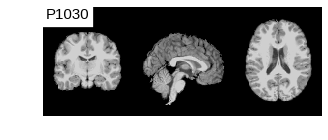

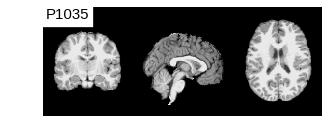

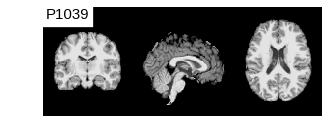

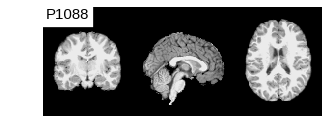

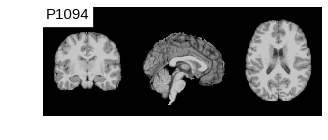

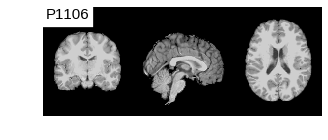

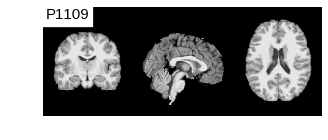

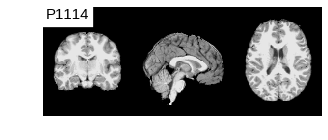

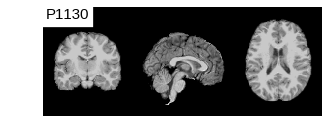

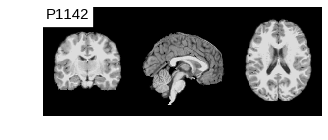

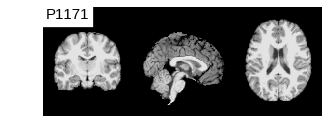

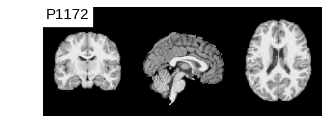

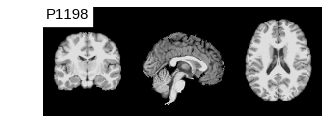

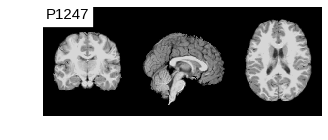

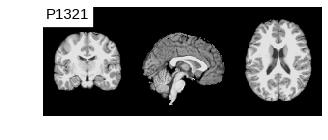

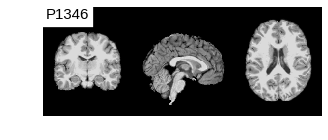

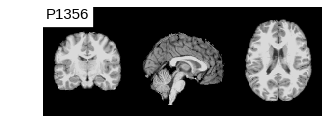

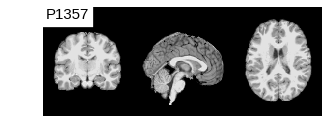

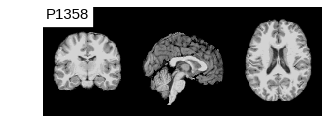

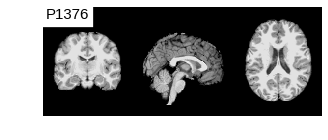

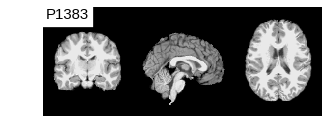

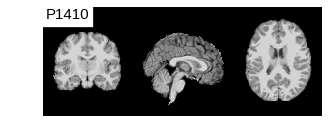

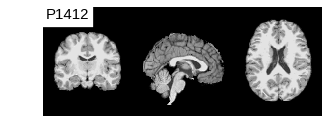

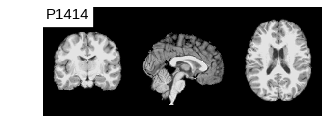

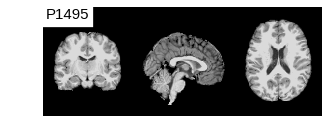

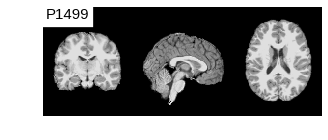

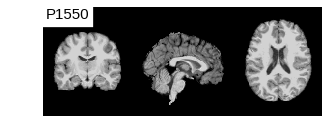

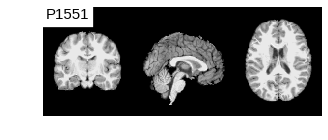

In [9]:
subjlist = get_subjlist()
for subj in subjlist:
    plot_anat(os.path.join(rsfmri_dir, subj), title=subj)

## Check registration of functional to structural with bbregister mincost 

The minimum cost is a measure of how well the median functional image from an individual registers to bbsurface (bbregister, the functional-to-structural transform). High numbers are bad, while low are good. Douglas Greve says there is no hard and fast threshold for it (although 0.86 is "too high"), and recommends computing the mean and stdev of the MinCost, then computing a z-score and picking "a threshold that you are comfortable with." Here we color-code outliers above 2 SD's from the mean.

Mean mincost: 0.5776
Standard dev of mincost 0.0594
Two SD's above mean: 0.6964


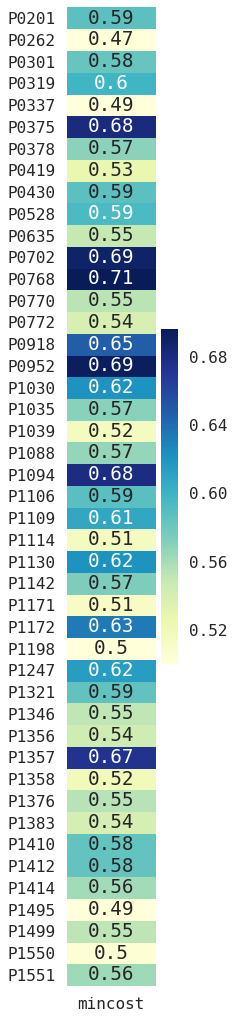

In [10]:
df=pd.DataFrame()
subjlist=get_subjlist()
for idx, subj in enumerate(subjlist):
    mincost=get_mincost(os.path.join(rsfmri_dir,subj), subj)
    df.set_value(subj, 'mincost', mincost)    
mean=round(float(df.mean()),4)
sd=round(float(df.std()),4)
threshold= round(float(mean + 2 * sd),4)

sns.set(context="poster", palette = "RdBu", font="monospace")
f, ax=plt.subplots(figsize=(2, 0.4*len(df.index)))
sns.heatmap(df, annot = True, cmap= "YlGnBu", linewidths = 0, vmax= threshold, vmin = 0.5, )
mincost_df = df
print "Mean mincost:", mean
print "Standard dev of mincost", sd
print "Two SD's above mean:", threshold

### If you ran the previous cell and would like the subject-wise mincost outputted in csv form: ###

Indicate an output directory for the csv file below. 

In [11]:
csv_outdir = '/data/picsl/mackey_group/Ursula/ping/analyses/10to13/'  # USER OPTION

mincost_df.to_csv(os.path.join(csv_outdir, 'mincost_summary.csv'))

# Motion & Outliers #

In [12]:
def count_outliers(subj_path):
    if ran_topup == True:
        outlier_file = os.path.join(subj_path,'resting', 'qa', 'art', 
                                    'art.rest_01_roi_corrected_outliers.txt')
    else:
        outlier_file = os.path.join(subj_path,'resting', 'qa', 'art', 
                                    'art.rest_01_outliers.txt')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        outliers = np.genfromtxt(outlier_file)
    return np.prod(outliers.shape)

### Check percentage of outliers per run ###

Displays a heatmap of the percentage of outliers detected in the resting state time series. Darker = more outliers.

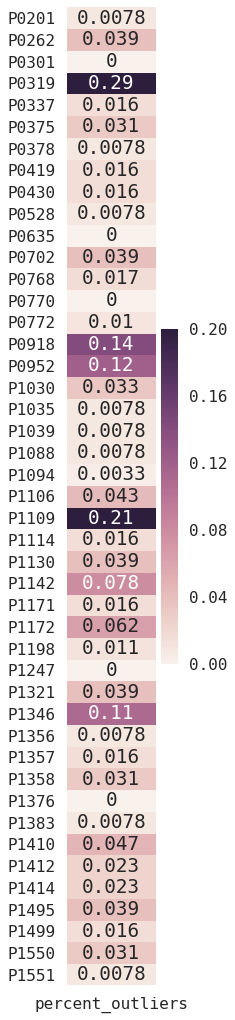

In [13]:
df = pd.DataFrame()
subjlist = get_subjlist()
for idx, subj in enumerate(subjlist):
    num_outliers = count_outliers(os.path.join(rsfmri_dir, subj)) 
    num_vols = get_num_vols(subj)
    perc_outliers = float(num_outliers)/num_vols
    df.set_value(subj, 'percent_outliers', perc_outliers)
    
sns.set(context="poster", font="monospace")
f, ax = plt.subplots(figsize=(2, 0.4*len(df.index)))
sns.heatmap(df, linewidths=0, annot=True, vmax=outlier_threshold/100., vmin=0)
outlier_df = df

### If you ran the previous cell and would like the outlier percentages outputted in csv form: ###

Indicate an output directory for the csv file below. 

In [14]:
csv_outdir = '/data/picsl/mackey_group/Ursula/ping/analyses/10to13/'  # USER OPTION

outlier_df.to_csv(os.path.join(csv_outdir, 'outlier_summary.csv'))

### Check average motion across the run (mean compnorm) ###

Displays a heatmap of the average displacement detected in the resting state time series. Darker = more motion. We currently use 1mm avg comp norm as the threshold for excluding children.

In [36]:
def avg_compnorm(subj_path):
    if ran_topup == True:
        compnorm_file = os.path.join(subj_path,'resting', 'qa', 'art', 
                                    'norm.rest_01_roi_corrected.txt')
    else:
        compnorm_file = os.path.join(subj_path,'resting', 'qa', 'art', 
                                    'norm.rest_01.txt')
    with warnings.catch_warnings():
        #warnings.simplefilter("ignore")
        avgcompnorm = np.genfromtxt(compnorm_file)
       # print avgcompnorm
    return np.mean(avgcompnorm)

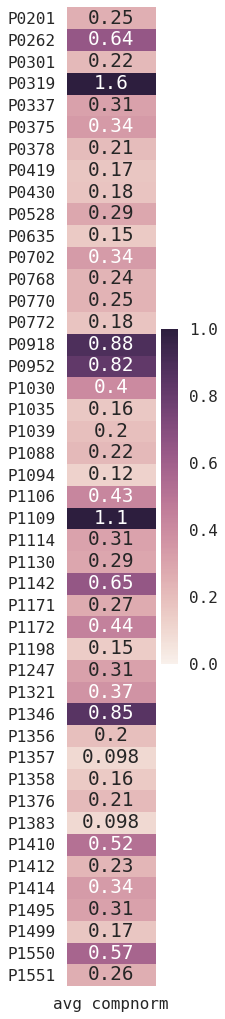

In [38]:
df = pd.DataFrame()
subjlist = get_subjlist()
for idx, subj in enumerate(subjlist):
    meancompnorm = avg_compnorm(os.path.join(rsfmri_dir, subj)) 
    df.set_value(subj, 'avg compnorm', meancompnorm)
    
sns.set(context="poster", font="monospace")
f, ax = plt.subplots(figsize=(2, 0.4*len(df.index)))
sns.heatmap(df, linewidths=0, annot=True, vmax=1, vmin=0)
compnorm_df = df

### If you ran the previous cell and would like the outlier percentages outputted in csv form: ###

Indicate an output directory for the csv file below. 

In [40]:
csv_outdir = '/data/picsl/mackey_group/Ursula/ping/analyses/10to13/'  # USER OPTION

compnorm_df.to_csv(os.path.join(csv_outdir, 'compnorm_summary.csv'))

# Segmentation Masks #

In [15]:
def plot_mask_only(subj_path, title, fig=None, ax=None):
    anat2target = os.path.join(subj_path, 'resting', 'mask_files', 'native_brain_mask.nii.gz')
    close = False
    if ax is None:
        fig = plt.figure(figsize=(5, 2))
        ax = fig.gca()
        close = True
    display = nlp.plot_anat(anat_img=anat2target, display_mode= 'z', cut_coords=5, annotate=False,
                            draw_cross=False, title=title, figure=fig, axes=ax)
    if close:
        plt.show()
        display.close()
def plot_mask(subj_path, mask, title, fig=None, ax=None):
    bg = os.path.join(subj_path, 'resting', 'mask_files', 'native_brain_mask.nii.gz')
    close = False
    if ax is None:
        fig = plt.figure(figsize=(5, 2))
        ax = fig.gca()
        close = True
    display = nlp.plot_roi(roi_img=mask, bg_img=bg, black_bg=True, display_mode='ortho',
                           draw_cross=False, figure=fig, axes=ax, title=title)
    if close:
        plt.show()
        display.close()
    
def count_noise_regressors(subj_path):
    noise_components = pd.read_csv(os.path.join(subj_path, 'resting', 'regress', 
                                            '_makecompcorrfilter0', 'noise_components.txt'), 
                               delimiter=' ', header=None)
    num_noise_regressors = len(noise_components.columns)
    return num_noise_regressors

### Check the  functional image mask for areas of dropout

This was intended to show areas where the mask may not have caught the brain due to dropout. However, I'm not certain this is really telling us anything, given that alignment could be different across subjects. 

_(to be added/modified)_

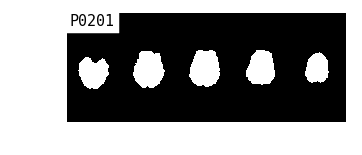

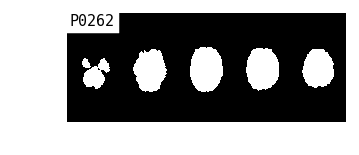

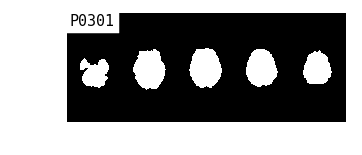

/data/picsl/mackey_group/Ursula/miniconda2/lib/python2.7/site-packages/nilearn/image/resampling.py:468: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


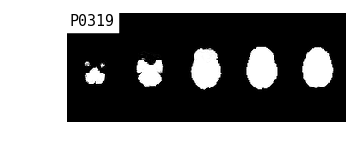

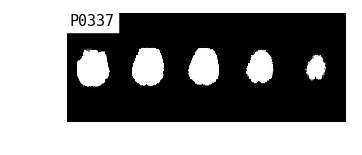

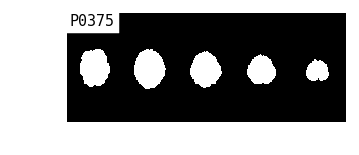

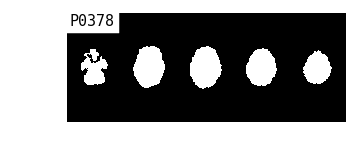

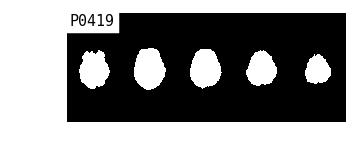

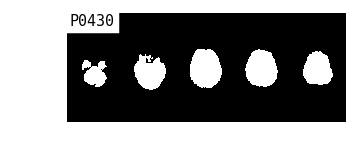

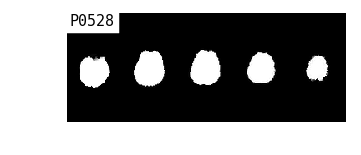

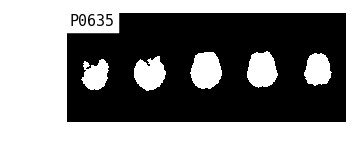

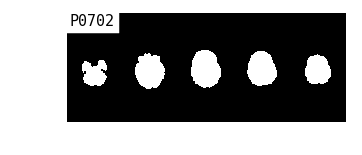

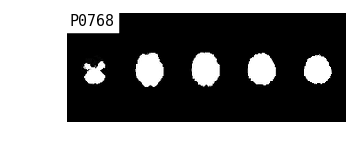

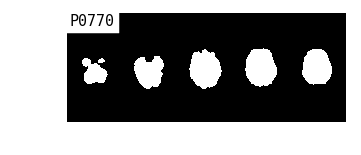

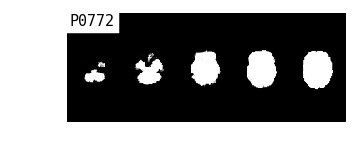

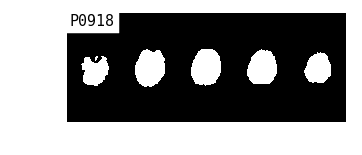

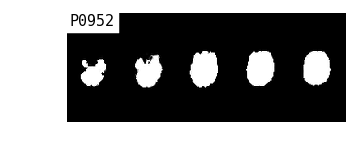

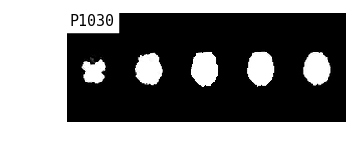

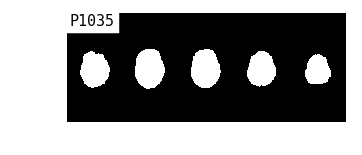

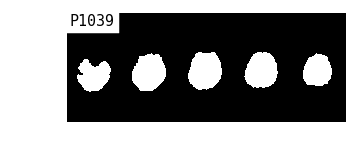

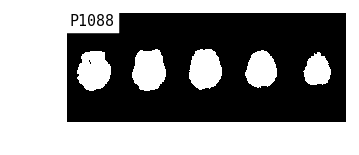

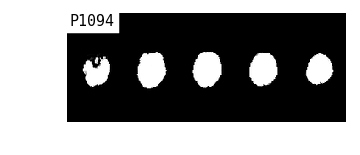

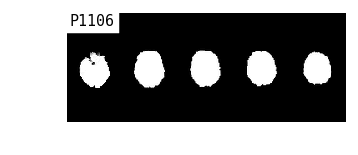

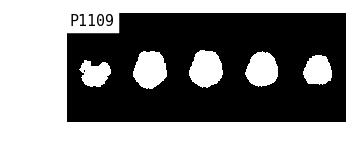

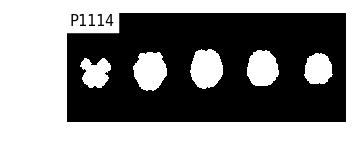

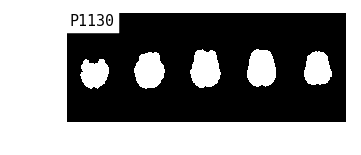

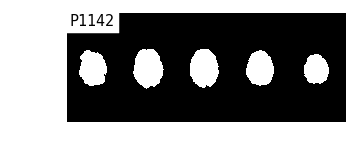

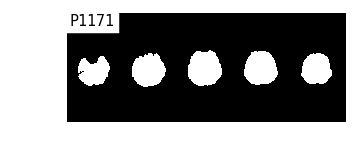

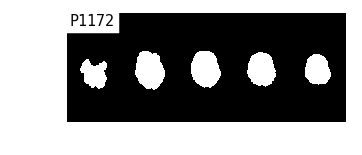

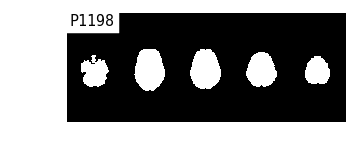

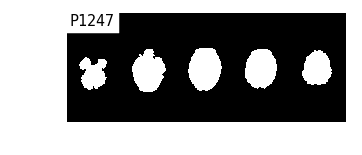

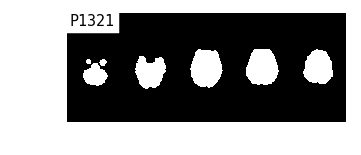

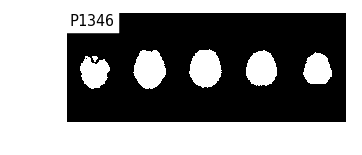

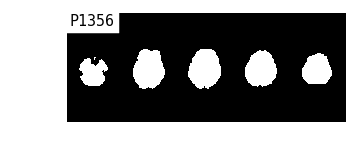

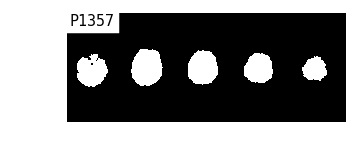

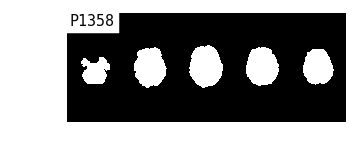

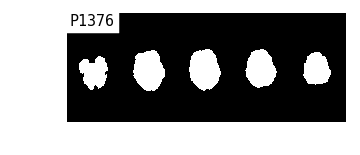

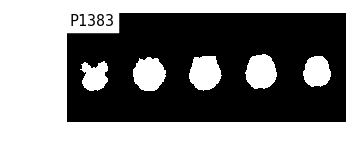

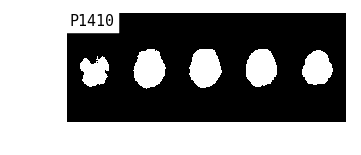

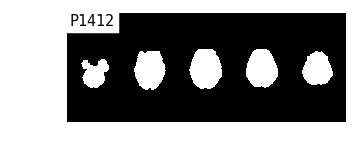

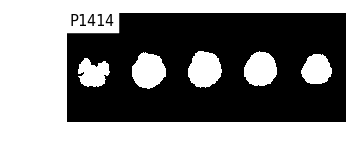

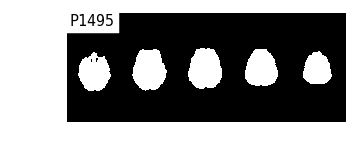

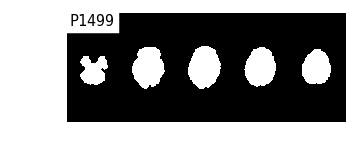

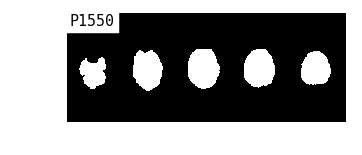

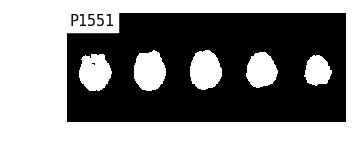

In [16]:
subjlist = get_subjlist()
for subj in subjlist:
    plot_mask_only(os.path.join(rsfmri_dir,subj),title=subj)

### Check that the CSF and WM masks were correctly segmented ###

Displays cross-sections of the segmentations (blue, binarized) produced by FSL's FAST tool, overlaid on a mask of the median functional image. Check to see if any of the segmentation masks are empty files.

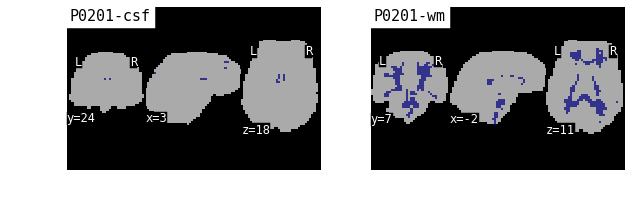

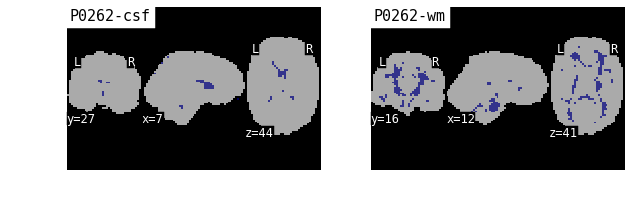

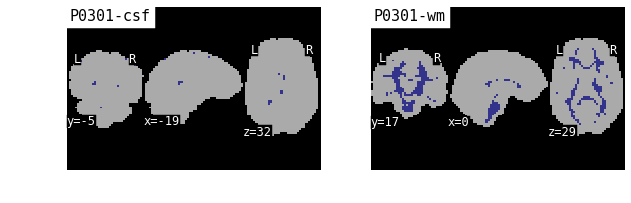

/data/picsl/mackey_group/Ursula/miniconda2/lib/python2.7/site-packages/nilearn/image/resampling.py:468: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


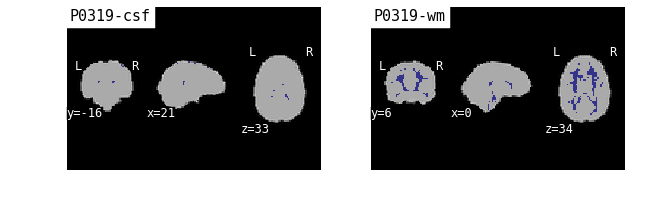

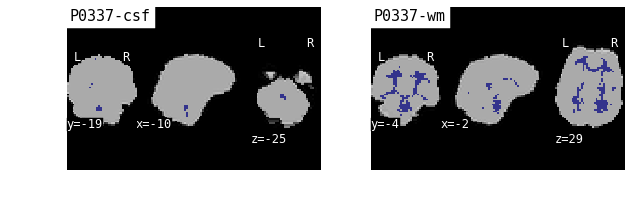

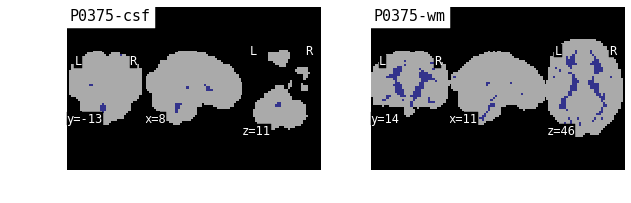

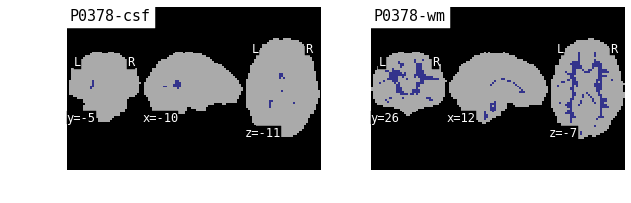

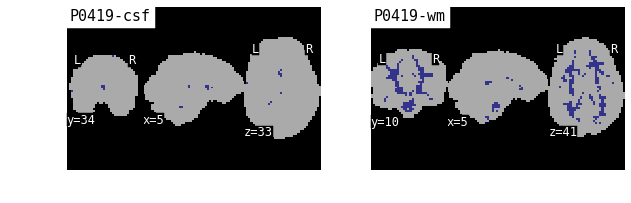

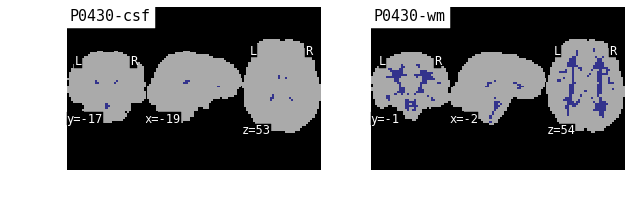

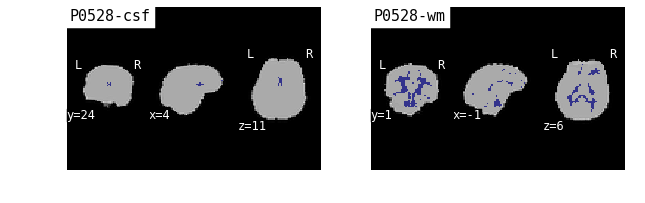

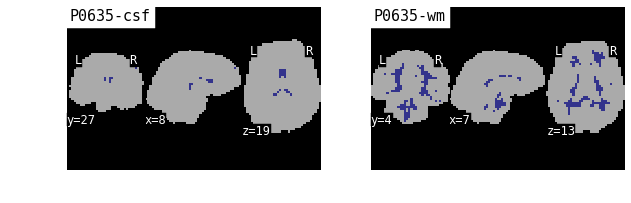

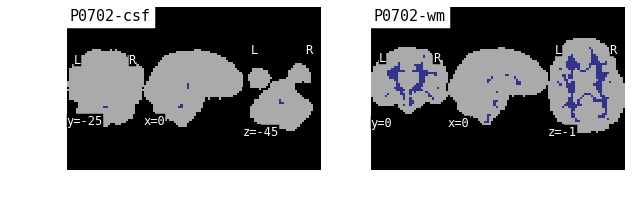

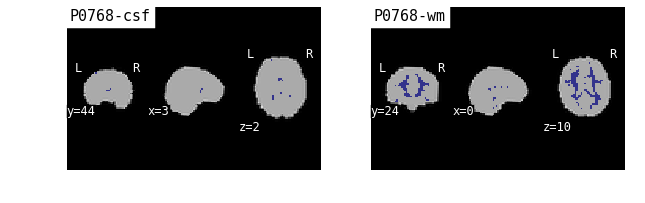

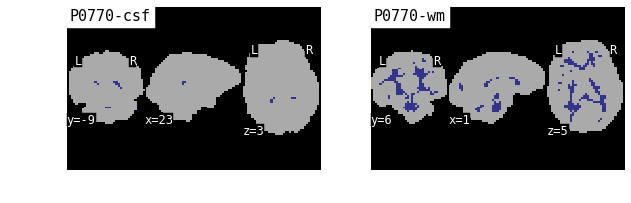

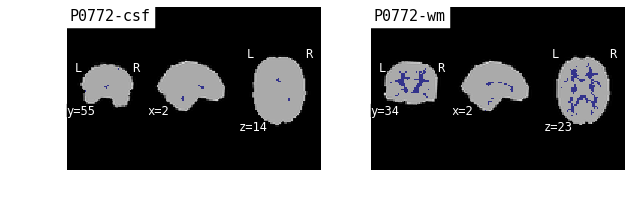

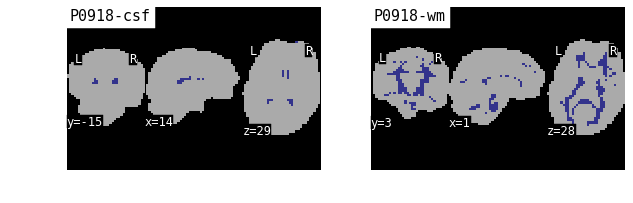

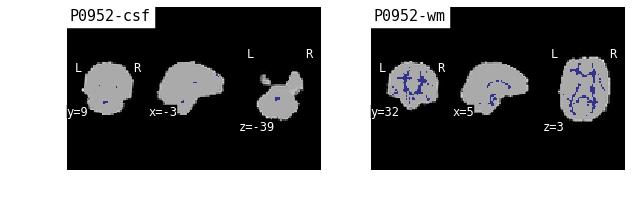

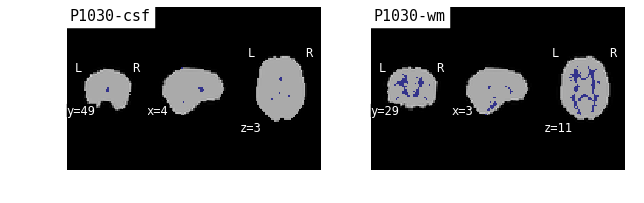

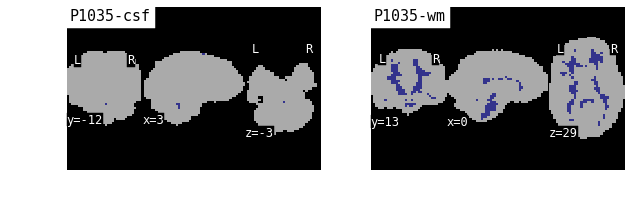

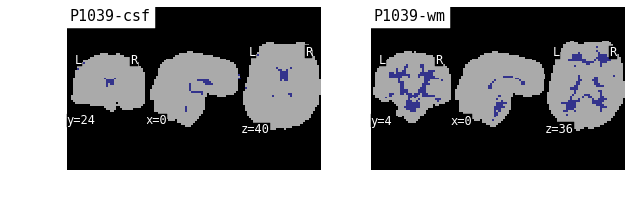

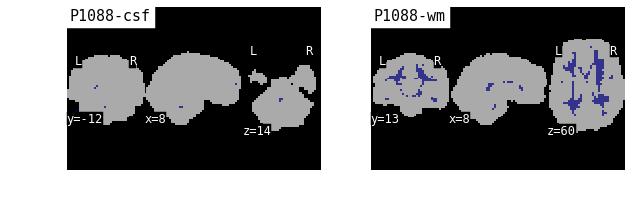

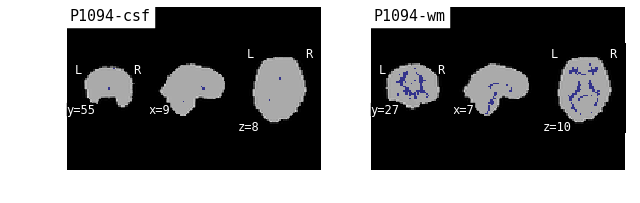

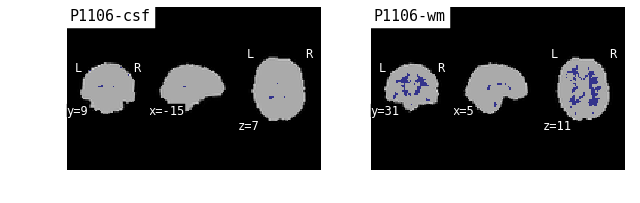

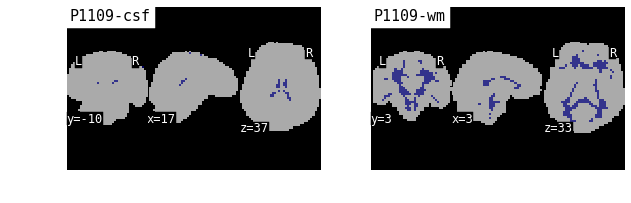

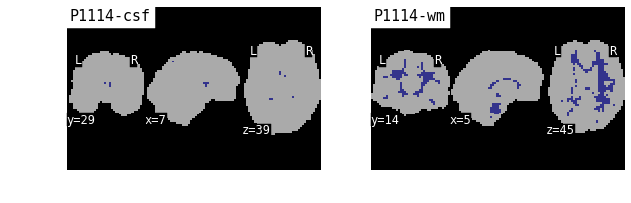

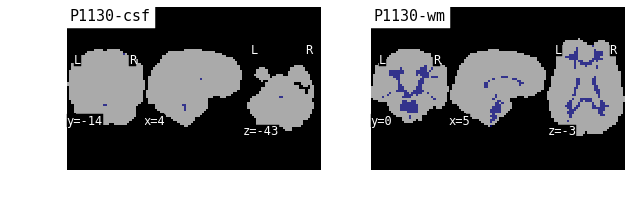

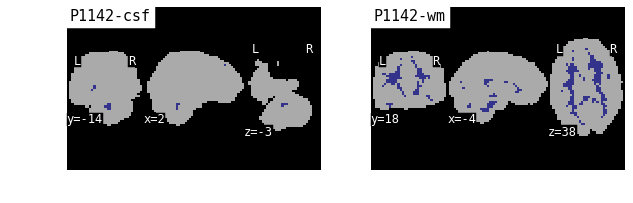

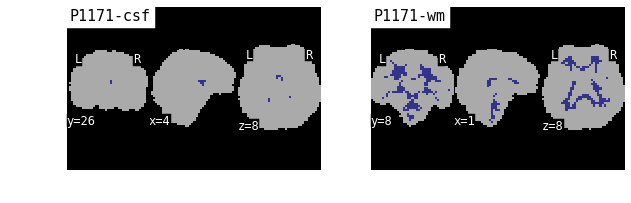

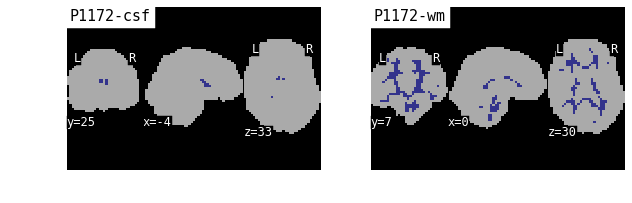

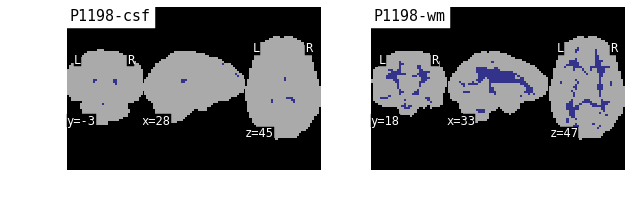

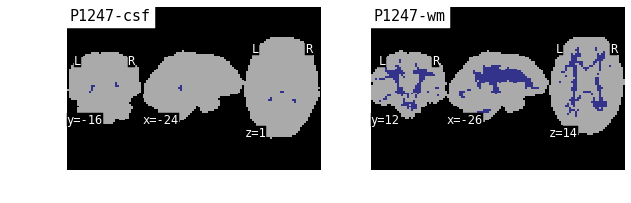

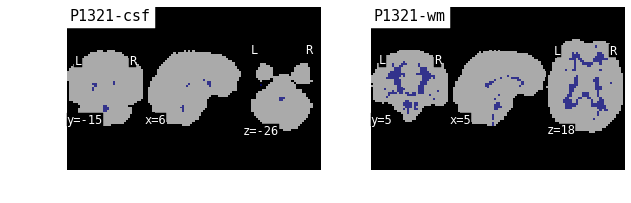

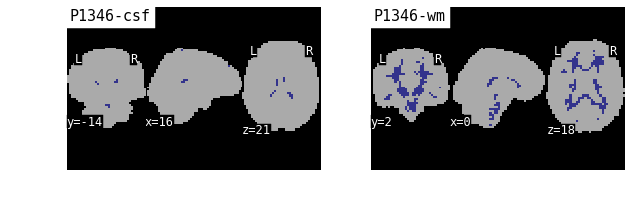

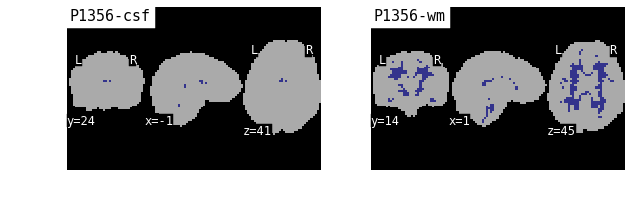

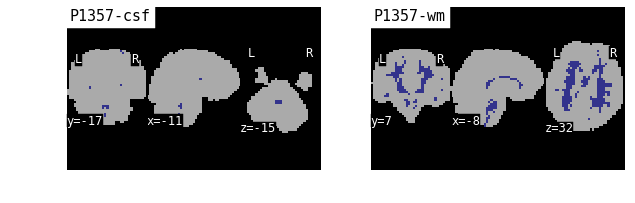

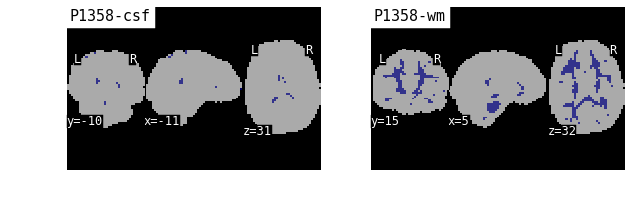

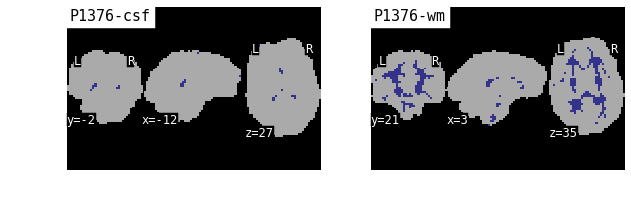

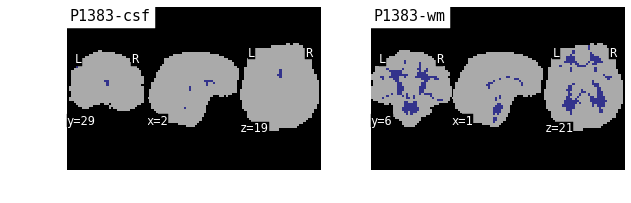

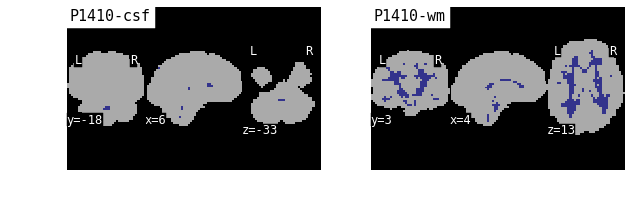

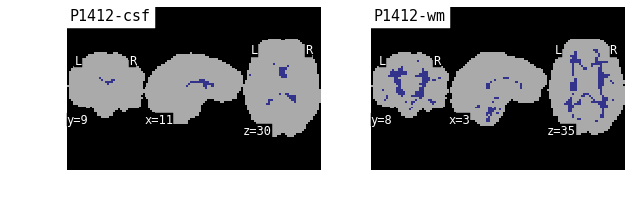

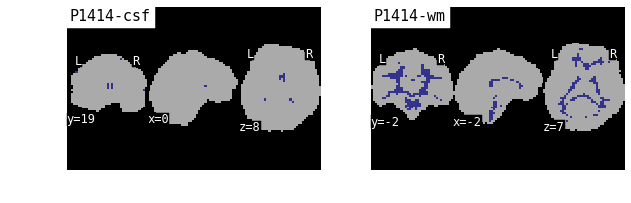

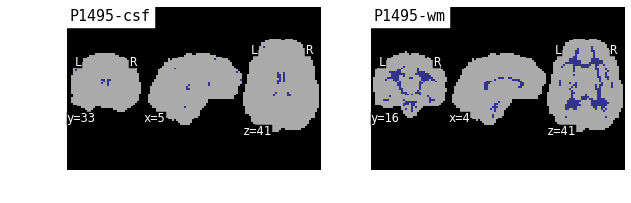

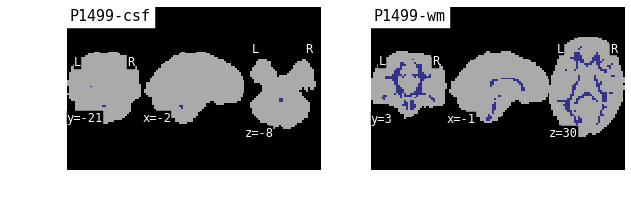

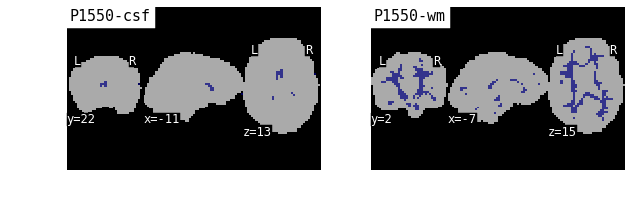

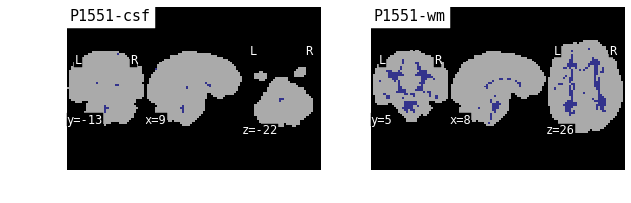

In [17]:
subjlist = get_subjlist()
for subj in subjlist:
    mask_dir = os.path.join(rsfmri_dir, subj, 'resting', 'mask_files')
    csf_mask = os.path.join(mask_dir, 'compcor_csf.nii.gz')
    wm_mask = os.path.join(mask_dir, 'compcor_wm.nii.gz')
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for i, seg in enumerate([(csf_mask, 'csf'), (wm_mask, 'wm')]):
        plot_mask(os.path.join(rsfmri_dir, subj), seg[0], subj+'-'+seg[1], fig=fig, ax=ax[i])
    plt.show()
    plt.close(fig)

### Check if GLM of noise components contains incorrect number of regressors (due to FAST breaking) ###

Supplement to the previous cell. If FAST did not produce the correct segmentations, the GLM used for regressing out physiological noise will not contain the expected number of noise components. This cell prints out any subjects that do not have the expected number.  

In [18]:
subjlist = get_subjlist()
for subj in subjlist:
    num_noise_regressors = count_noise_regressors(os.path.join(rsfmri_dir, subj))
    num_outliers = count_outliers(os.path.join(rsfmri_dir, subj))
    if 25 + num_outliers != num_noise_regressors:
        print subj

# Topup #

_(To be added.)_

---
# Extracting the average time series from aparc ROIs

The preprocessing script already does this (samples in functional space), but outputs all of the aparc ROIs together in a single file. The following cells can be used to help parse out the particular ROIs you're interested in.

**Note**: here we're sampling from the unsmoothed functional data; there is also smoothed data available.

Each subject output directory has a parcellations/aparc/rest_01_summary.stats file - check one of these files to see how the different FreeSurfer ROIs are named, and enter them into the roi_list variable below:

In [3]:
roi_list = ["ctx.lh.precentral","ctx.lh.paracentral","ctx.lh.postcentral","ctx.lh.middletemporal","ctx.rh.precentral","ctx.rh.paracentral","ctx.rh.postcentral","ctx.rh.precuneus",
            "ctx.lh.lateraloccipital","ctx.lh.pericalcarine","ctx.rh.lateraloccipital","ctx.rh.pericalcarine" ]

The next cell will output a csv file containing the time series of each ROI given in roi_list, for each subject in your subjlist. Indicate an output directory for the csv file below. 

In [7]:
csv_outdir = '/data/picsl/mackey_group/Ursula/analyses/'   # USER OPTION

subjlist = get_subjlist()
for subj in subjlist:
    summary = pd.read_csv(os.path.join(rsfmri_dir, subj, 'resting', 'parcellations', 'aparc', 
                                       'rest_01_summary.stats'), 
                          header=None, comment='#', delim_whitespace=True, index_col=0)
    meants_df = pd.DataFrame()
    for roi in roi_list:
        roi_idx = summary[summary[4].str.contains(roi)].index.values
        meants = pd.read_csv(os.path.join(rsfmri_dir, subj, 'resting', 'parcellations', 'aparc', 
                                          'rest_01_avgwf.txt'), 
                             header=None, delim_whitespace=True, usecols=roi_idx-1, names=[roi])
        meants_df = pd.concat([meants_df, meants], axis=1)
    meants_df.to_csv(os.path.join(csv_outdir, '%s_rest_aparc_meants.csv' % subj), sep=',', index=False)